In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

from keras.models import model_from_json
import cv2, os
from keras.layers import Flatten
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
train_dir = r"dataset/ImageEmotion (85-15)/train"
test_dir = r"dataset/ImageEmotion (85-15)/test"

SEED = 12
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 128
momentum = 0.9
EPOCHS = 500
#FINE_TUNING_EPOCHS = 30
LR = 0.001
NUM_CLASSES = 8
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['Amusement', 'Anger', 'Awe', 'Contentment', 'Disgust', 'Excitement', 'Fear', 'Sadness']
CLASS_LABELS_EMOJIS = ["🥳", "😡", "😯", "😌", "🤢" ,"🤩", "😱" , "😔" ]

In [40]:
#loading features required
train_CNNfeatures = np.load(r'FeatureFiles/MobileNetV2_train_CNNfeatures.npy', mmap_mode='r')
print('Loaded train CNN features')
test_CNNfeatures = np.load(r'FeatureFiles/MobileNetV2_test_CNNfeatures.npy', mmap_mode='r')
print('Loaded test CNN features')
train_lowfeatures = np.load(r'FeatureFiles/train_lowfeatures.npy')
print('Loaded train low features')
test_lowfeatures = np.load(r'FeatureFiles/test_lowfeatures.npy')
print('Loaded test low features')
train_semanticfeatures = np.load(r'FeatureFiles/train_semanticfeatures_normalized.npy')
print('Loaded train semantic features')
test_semanticfeatures = np.load(r'FeatureFiles/test_semanticfeatures_normalized.npy')
print('Loaded test semantic features')
train_mainobject = np.load(r'FeatureFiles/MobileNetV2_train_MainObject_data.npy')
print('Loaded train mainobject data')
test_mainobject = np.load(r'FeatureFiles/MobileNetV2_test_MainObject_data.npy')
print('Loaded test main object data')

train_labels = np.load(r'FeatureFiles/train_labels.npy')
print('Loaded train labels')
test_labels = np.load(r'FeatureFiles/test_labels.npy')
print('Loaded test labels')

Loaded train CNN features
Loaded test CNN features
Loaded train low features
Loaded test low features
Loaded train semantic features
Loaded test semantic features
Loaded train mainobject data
Loaded test main object data
Loaded train labels
Loaded test labels


In [6]:
#taking GAP of CNN features
train_CNNfeatures_GAP = tf.keras.layers.GlobalAveragePooling2D()(train_CNNfeatures)
test_CNNfeatures_GAP = tf.keras.layers.GlobalAveragePooling2D()(test_CNNfeatures)

2022-08-02 15:49:18.200976: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-02 15:49:18.201163: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-02 15:49:18.220859: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/stud1/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-08-02 15:49:18.220868: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://w

In [9]:
print(train_CNNfeatures_GAP.shape)
print(test_CNNfeatures_GAP.shape)

(18559, 1280)
(3277, 1280)


In [48]:
#Concatinating all domain-respective features
train_features = tf.concat([train_semanticfeatures, train_CNNfeatures_GAP, train_lowfeatures], axis=1)
test_features = tf.concat([test_semanticfeatures, test_CNNfeatures_GAP, test_lowfeatures], axis=1)

In [49]:
print(train_features.shape)
print(test_features.shape)

(18559, 1440)
(3277, 1440)


In [77]:
def classifier(inputs):
    #x = tf.keras.layers.Dense(3000, activation='relu', 
     #                         kernel_regularizer= tf.keras.regularizers.l2(0.001)
     #                        )(inputs)
    #x = tf.keras.layers.Dropout(0.5)(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(1500, activation='relu', 
                              kernel_regularizer= tf.keras.regularizers.l2(0.001)
                             )(inputs)
    #x = tf.keras.layers.Dense(1000, activation='relu', 
    #                          kernel_regularizer= tf.keras.regularizers.l2(0.001)
    #                         )(inputs)
    x = tf.keras.layers.Dense(1000, activation='relu', 
                              kernel_regularizer= tf.keras.regularizers.l2(0.001)
                             )(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    #x = tf.keras.layers.Dense(500, activation='relu', 
    #                          kernel_regularizer= tf.keras.regularizers.l2(0.001)
    #                         )(x)
    x = tf.keras.layers.Dense(100, activation='relu', 
                              kernel_regularizer= tf.keras.regularizers.l2(0.001)
                             )(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', 
                              #kernel_regularizer= tf.keras.regularizers.l2(0.01),
                              name='classification')(x)
    
    return x
        
def final_model(inputs):
    classification_output = classifier(inputs)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(1440,))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs= inputs, outputs= classification_output)
    model.compile(optimizer=tf.keras.optimizers.Nadam(0.001), 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  
    return model

In [78]:
model = define_compile_model()

model.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 1440)]            0         
                                                                 
 dense_61 (Dense)            (None, 1500)              2161500   
                                                                 
 dense_62 (Dense)            (None, 1000)              1501000   
                                                                 
 dense_63 (Dense)            (None, 100)               100100    
                                                                 
 classification (Dense)      (None, 8)                 808       
                                                                 
Total params: 3,763,408
Trainable params: 3,763,408
Non-trainable params: 0
_________________________________________________________________


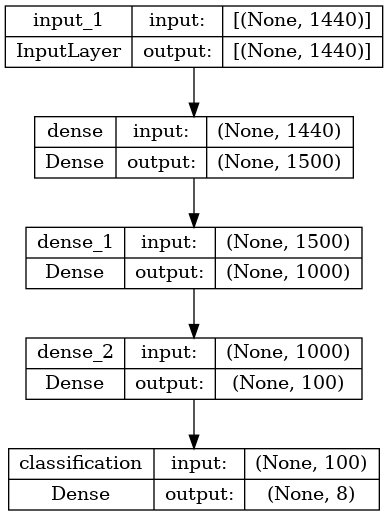

In [15]:
#for plotting model
import keras.utils.vis_utils
from importlib import reload
reload(keras.utils.vis_utils)


from keras.utils.vis_utils import plot_model    
plot_model(model, to_file='model_i1.png', show_shapes=True, show_layer_names=True)

In [52]:
checkpoint = ModelCheckpoint('MobileNetV2_CNN+Sem+LF-OnlyClassifier-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5', verbose=1, 
                        monitor='val_accuracy',save_best_only=True, mode='auto') 
#earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='auto')

In [ ]:
history = model.fit(train_features, train_labels,
                    batch_size = BATCH_SIZE,
                    epochs= 500,
                    validation_data = (test_features, test_labels),
                    validation_batch_size= BATCH_SIZE,
                    #callbacks= [checkpoint]
                    )

history = pd.DataFrame(history.history)

Epoch 1/500
 57/145 [==========>...................] - ETA: 2s - loss: 3.5779 - accuracy: 0.5436